In [1]:
import findspark
findspark.init('/home/elmo/Downloads/spark-2.4.5-bin-hadoop2.7')

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pyspark import SparkConf, SparkContext, SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

from pyspark.ml.feature import PCA
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import HashingTF,Tokenizer,IDF
from pyspark.ml.feature import Normalizer

from pyspark.ml.linalg import Vectors

from pyspark.ml.classification import LogisticRegression

from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import col
import pyspark.sql.types as T

# Load dataset using pandas

In [3]:
# Load Data Set to pandas
train = pd.read_csv("dataset/aps_failure_training_set.csv")
test = pd.read_csv("dataset/aps_failure_test_set.csv")

### Check dataset

#### - na values existed
#### - binary classification ( neg, pos )

In [4]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [5]:
train.dtypes

class     object
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
           ...  
ee_007    object
ee_008    object
ee_009    object
ef_000    object
eg_000    object
Length: 171, dtype: object

### Set up Spark Session ( mem_driv : 18g | core : 6 | mem_exe : 4g )

In [6]:
spark = (SparkSession.builder
                  .appName('Test')
                  .enableHiveSupport()
                  .config("spark.executor.memory", "4G")
                  .config("spark.driver.memory","18G")
                  .config("spark.executor.cores","6")
                  .config("spark.python.worker.memory","4G")
                  .config("spark.driver.maxResultSize","0")
                  .config("spark.sql.crossJoin.enabled", "true")
                  .config("spark.serializer","org.apache.spark.serializer.KryoSerializer")
                  .config("spark.default.parallelism","2")
                  .getOrCreate())

### Load pandas dataframe into spark session for better computing

In [7]:
spark.sparkContext.setLogLevel('INFO')

spark_df = spark.createDataFrame(train)
spark_test_df = spark.createDataFrame(test)

### Check data schema in spark 

#### All type are string except aa_000. We need to make everything into float because of the decimal number is easier to handle (except class column)

In [8]:
spark_df.printSchema()

root
 |-- class: string (nullable = true)
 |-- aa_000: long (nullable = true)
 |-- ab_000: string (nullable = true)
 |-- ac_000: string (nullable = true)
 |-- ad_000: string (nullable = true)
 |-- ae_000: string (nullable = true)
 |-- af_000: string (nullable = true)
 |-- ag_000: string (nullable = true)
 |-- ag_001: string (nullable = true)
 |-- ag_002: string (nullable = true)
 |-- ag_003: string (nullable = true)
 |-- ag_004: string (nullable = true)
 |-- ag_005: string (nullable = true)
 |-- ag_006: string (nullable = true)
 |-- ag_007: string (nullable = true)
 |-- ag_008: string (nullable = true)
 |-- ag_009: string (nullable = true)
 |-- ah_000: string (nullable = true)
 |-- ai_000: string (nullable = true)
 |-- aj_000: string (nullable = true)
 |-- ak_000: string (nullable = true)
 |-- al_000: string (nullable = true)
 |-- am_0: string (nullable = true)
 |-- an_000: string (nullable = true)
 |-- ao_000: string (nullable = true)
 |-- ap_000: string (nullable = true)
 |-- aq_000:

In [9]:
spark_df_cast_train = spark_df
spark_df_cast_test = spark_test_df

for col_name in spark_df_cast_train.columns[1::]:
    spark_df_cast_train = spark_df_cast_train.withColumn(col_name,col(col_name).cast("float"))

for col_name in spark_df_cast_test.columns[1::]:
    spark_df_cast_test = spark_df_cast_test.withColumn(col_name,col(col_name).cast("float"))

In [10]:
# spark_df_cast_train.printSchema()
spark_df_cast_test.printSchema()

root
 |-- class: string (nullable = true)
 |-- aa_000: float (nullable = true)
 |-- ab_000: float (nullable = true)
 |-- ac_000: float (nullable = true)
 |-- ad_000: float (nullable = true)
 |-- ae_000: float (nullable = true)
 |-- af_000: float (nullable = true)
 |-- ag_000: float (nullable = true)
 |-- ag_001: float (nullable = true)
 |-- ag_002: float (nullable = true)
 |-- ag_003: float (nullable = true)
 |-- ag_004: float (nullable = true)
 |-- ag_005: float (nullable = true)
 |-- ag_006: float (nullable = true)
 |-- ag_007: float (nullable = true)
 |-- ag_008: float (nullable = true)
 |-- ag_009: float (nullable = true)
 |-- ah_000: float (nullable = true)
 |-- ai_000: float (nullable = true)
 |-- aj_000: float (nullable = true)
 |-- ak_000: float (nullable = true)
 |-- al_000: float (nullable = true)
 |-- am_0: float (nullable = true)
 |-- an_000: float (nullable = true)
 |-- ao_000: float (nullable = true)
 |-- ap_000: float (nullable = true)
 |-- aq_000: float (nullable = true

In [11]:
spark_df_cast_test.show()

+-----+--------+------+------------+------+------+------+------+------+------+--------+---------+---------+---------+---------+--------+-------+---------+------+------+------+-------+--------+---------+---------+---------+--------+------+------+-------+------+------+------+------+-------+-------+--------+-------+--------+---------+---------+---------+------+-------+-------+-------+--------+---------+---------+---------+--------+-------+------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------+---------+------+------+------+------+---------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+--------+---------+---------+---------+---------+-------+-------+--------+---------+---------+---------+--------+------+------+------+---------+--------+---------+------+------+------+------+--------+--------+---------+---------+---------+--------+--------+--------+------+------+---------+------+-------+------+------

#### Change null / NaN / na to 0.0 (make sure all the nullable turns to false except class column)

In [12]:
spark_df_cast_train = spark_df_cast_train.na.fill(0.0)
spark_df_cast_test = spark_df_cast_test.na.fill(0.0)

In [13]:
spark_df_cast_train.printSchema()

root
 |-- class: string (nullable = true)
 |-- aa_000: float (nullable = false)
 |-- ab_000: float (nullable = false)
 |-- ac_000: float (nullable = false)
 |-- ad_000: float (nullable = false)
 |-- ae_000: float (nullable = false)
 |-- af_000: float (nullable = false)
 |-- ag_000: float (nullable = false)
 |-- ag_001: float (nullable = false)
 |-- ag_002: float (nullable = false)
 |-- ag_003: float (nullable = false)
 |-- ag_004: float (nullable = false)
 |-- ag_005: float (nullable = false)
 |-- ag_006: float (nullable = false)
 |-- ag_007: float (nullable = false)
 |-- ag_008: float (nullable = false)
 |-- ag_009: float (nullable = false)
 |-- ah_000: float (nullable = false)
 |-- ai_000: float (nullable = false)
 |-- aj_000: float (nullable = false)
 |-- ak_000: float (nullable = false)
 |-- al_000: float (nullable = false)
 |-- am_0: float (nullable = false)
 |-- an_000: float (nullable = false)
 |-- ao_000: float (nullable = false)
 |-- ap_000: float (nullable = false)
 |-- aq_00

#### Change neg to 0 and pos to 1 inside class column

In [14]:
from pyspark.sql.functions import when

spark_df_cast_train_upd = spark_df_cast_train.withColumn('class', when(col('class') == 'neg', 0.0).otherwise(col('class')))
spark_df_cast_train_upd = spark_df_cast_train_upd.withColumn('class', when(col('class') == 'pos', 1.0).otherwise(col('class')))

spark_df_cast_test_upd = spark_df_cast_test.withColumn('class', when(col('class') == 'neg', 0.0).otherwise(col('class')))
spark_df_cast_test_upd = spark_df_cast_test_upd.withColumn('class', when(col('class') == 'pos', 1.0).otherwise(col('class')))

#### Test spark groupby for class to see only 2 class available

In [15]:
spark_df_cast_train_upd.groupBy('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|  1.0| 1000|
|  0.0|59000|
+-----+-----+



In [16]:
spark_df_cast_test_upd.groupBy('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|  1.0|  375|
|  0.0|15625|
+-----+-----+



#### Check class dtype, we need it to be double / float

In [17]:
print(spark_df_cast_train_upd['class'].dtypes)
print(spark_df_cast_test_upd['class'].dtypes)

Column<b'class[dtypes]'>
Column<b'class[dtypes]'>


In [18]:
train_spark = spark_df_cast_train_upd.withColumn("class", spark_df_cast_train_upd["class"].cast(T.FloatType()))
test_spark = spark_df_cast_test_upd.withColumn("class", spark_df_cast_test_upd["class"].cast(T.FloatType()))

In [19]:
train_spark.printSchema()
test_spark.printSchema()

root
 |-- class: float (nullable = true)
 |-- aa_000: float (nullable = false)
 |-- ab_000: float (nullable = false)
 |-- ac_000: float (nullable = false)
 |-- ad_000: float (nullable = false)
 |-- ae_000: float (nullable = false)
 |-- af_000: float (nullable = false)
 |-- ag_000: float (nullable = false)
 |-- ag_001: float (nullable = false)
 |-- ag_002: float (nullable = false)
 |-- ag_003: float (nullable = false)
 |-- ag_004: float (nullable = false)
 |-- ag_005: float (nullable = false)
 |-- ag_006: float (nullable = false)
 |-- ag_007: float (nullable = false)
 |-- ag_008: float (nullable = false)
 |-- ag_009: float (nullable = false)
 |-- ah_000: float (nullable = false)
 |-- ai_000: float (nullable = false)
 |-- aj_000: float (nullable = false)
 |-- ak_000: float (nullable = false)
 |-- al_000: float (nullable = false)
 |-- am_0: float (nullable = false)
 |-- an_000: float (nullable = false)
 |-- ao_000: float (nullable = false)
 |-- ap_000: float (nullable = false)
 |-- aq_000

In [20]:
# Create function class attribute processing
def index_processor(df):
    indexer = StringIndexer(inputCol="class", outputCol="label")
    indexed = indexer.fit(df).transform(df)
    return indexed

# Create function for vector assembler processing of features
def vector_assembler_processor(indexed):
    indexed_1 = indexed
    vector_features = indexed_1.drop('class', 'label').columns
    vectorAssembler = VectorAssembler(inputCols= vector_features, outputCol="features")
    expr = [col(c).cast("Double").alias(c)
            for c in vectorAssembler.getInputCols()]
    indexed_1 = indexed_1.select(*expr)
    indexed_1 = indexed_1.fillna(0)
    features_vectorized = vectorAssembler.transform(indexed_1)
    return features_vectorized  


# Make final data frame to train the model
def make_df_train(features_vectorized, indexed):
    df_train = features_vectorized.select("features")
    label = indexed.select("label")
    df_train = df_train.withColumn('row_index', f.monotonically_increasing_id())
    label=label.withColumn('row_index', f.monotonically_increasing_id())
    df_train = df_train.join(label, on=["row_index"]).sort("row_index").drop("row_index")
    return df_train

# Compile all above function to one function for easy processing of data set
def processor(df):
    indexed = index_processor(df)
    features_vectorized = vector_assembler_processor(indexed)
    df_processed = make_df_train(features_vectorized, indexed)
    return df_processed

# Pre process training data frame
df_train = processor(train_spark)

# Create model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(df_train)

# Traing the model
prediction = model.transform(df_train)
print("Prediction schema")
prediction.printSchema()

# Evaluate the model performance on traing data set
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")
print("Evaluation score on training set.....")    
print(binEval.evaluate(prediction))

Prediction schema
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

Evaluation score on training set.....
0.9833333333333333


In [21]:
# Pre process test data frame
df_test = processor(test_spark) 

# Make prediction on the test data frame
test_prediction = model.transform(df_test)
# Evaluate model performance on test data frame
print("Evaluation score on test set.....")
print(binEval.evaluate(test_prediction))

Evaluation score on test set.....
0.9765625


classification report...
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15625
         1.0       1.00      1.00      1.00       375

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000

Confusion matrix plot...


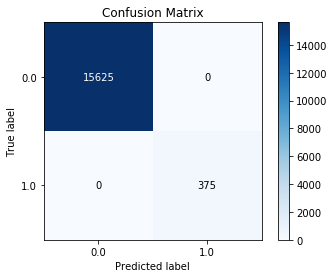

In [26]:
# Import required libraries

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer
import scikitplot as skplt
from tqdm import tqdm

# Create numpy arrays of True labels and predicted labels
y_test_norm = np.array(df_test.select("label").collect())
y_pred_norm = np.array(test_prediction.select("label").collect())

# Create classification report and confusion matrix plot 
print("classification report...")
print(classification_report(y_test_norm, y_pred_norm))
tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
print("Confusion matrix plot...")
skplt.metrics.plot_confusion_matrix(y_test_norm, y_pred_norm, normalize=False)
plt.show()

In [27]:
print("Total Cost for the model:", (10*fp + 500*fn))

Total Cost for the model: 0
